# A. Speech Emotion Recognition (SER) 

Feature Extraction: 
- GeMAPS (OpenSMILE)
- Full acoustic feature set (librosa)

Feature Selection: 
- Algorithm 1
- Algorithm 2
- Algorithm 1 + 2

Modeling Approach: 
**Traditional ML:** 
- Support Vector Machine (SVM) with Radial Basis Function (RBF) kernel 
- Random Forest 
- XGBoost (Extreme Gradient Boosting) 
- Gaussian Naive Bayes 
- k-Nearest Neighbors (k-NN) 
**Traditional DL:** 
- Convolutional Neural Network (CNN) with 2-3 convolutional layers, max pooling, and fully connected layers 
- Recurrent Neural Network (RNN) with LSTM (Long Short-Term Memory) or GRU (Gated Recurrent Unit) layers 
- Hybrid CNN-RNN 


Evaluation Strategy: 10-fold cross validation?? (GridSearchCV??) - less on more expensive tasks (FER/MER)




Total combinations for SER: 2 * 2 * 2 * 2 = 16 experiments 


In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..', '..')) # or the path to your source code
sys.path.insert(0, module_path)
from src.utils import load_iemocap, load_meld, load_emodb, load_ravdess, load_tess, load_crema_d, filter_emotions

iemocap = filter_emotions(load_iemocap())
meld = filter_emotions(load_meld())
emodb = filter_emotions(load_emodb())
ravdess = filter_emotions(load_ravdess())
tess = filter_emotions(load_tess())
crema_d = filter_emotions(load_crema_d())


Subfolders in the dataset: ['IEMOCAP_full_release']
Subfolders in the dataset: ['JSON files', 'MELD.Raw']
Subfolders in the raw data: ['dia47_utt11.mp4', 'dia35_utt2.mp4', 'dia47_utt9.mp4', 'dia167_utt14.mp4', 'dia232_utt4.mp4', '._dia118_utt11.mp4', 'dia34_utt2.mp4', 'dia268_utt8.mp4', 'dia233_utt4.mp4', '._dia39_utt1.mp4', '._dia230_utt3.mp4', 'dia137_utt0.mp4', '._dia268_utt11.mp4', '._dia231_utt3.mp4', 'dia136_utt0.mp4', '._dia38_utt1.mp4', '._dia34_utt16.mp4', '._dia128_utt2.mp4', 'dia28_utt7.mp4', 'dia195_utt8.mp4', 'dia22_utt15.mp4', '._dia129_utt2.mp4', '._dia100_utt5.mp4', 'dia29_utt7.mp4', 'dia103_utt2.mp4', 'final_videos_testdia48_utt3.mp4', 'dia154_utt12.mp4', '._dia95_utt11.mp4', '._dia205_utt1.mp4', 'dia102_utt2.mp4', 'dia107_utt8.mp4', 'dia253_utt11.mp4', '._dia52_utt5.mp4', 'dia175_utt3.mp4', 'dia93_utt0.mp4', '._dia272_utt0.mp4', '._dia192_utt5.mp4', 'dia174_utt3.mp4', '._dia53_utt5.mp4', 'dia175_utt13.mp4', 'dia92_utt0.mp4', 'dia191_utt2.mp4', 'dia77_utt1.mp4', 'dia25

In [2]:

# print label counts for each dataset
print("IEMOCAP label counts:", {label: len(samples) for label, samples in iemocap.items()})
print("EMODB label counts:", {label: len(samples) for label, samples in emodb.items()})
print("RAVDESS label counts:", {label: len(samples) for label, samples in ravdess.items()})
print("TESS label counts:", {label: len(samples) for label, samples in tess.items()})
print("CREMA-D label counts:", {label: len(samples) for label, samples in crema_d.items()})

IEMOCAP label counts: {'session': 4639, 'method': 4639, 'gender': 4639, 'emotion': 4639, 'n_annotators': 4639, 'agreement': 4639, 'path': 4639, 'label': 4639, 'filename': 4639}
EMODB label counts: {'filename': 454, 'label': 454}
RAVDESS label counts: {'filename': 1248, 'label': 1248}
TESS label counts: {'filename': 2800, 'label': 2800}
CREMA-D label counts: {'label': 7442, 'filename': 7442}



**1. GeMAPS (Geneva Minimalistic Acoustic Parameter Set):**

In [3]:
import pandas as pd
iemocap_feats = pd.read_csv("IEMOCAP_GeMAPS.csv")
emobd_feats = pd.read_csv("EMODB_GeMAPS.csv")
ravdess_feats = pd.read_csv("RAVDESS_GeMAPS.csv")
tess_feats = pd.read_csv("TESS_GeMAPS.csv")
crema_d_feats = pd.read_csv("CREMA-D_GeMAPS.csv")
meld_feats = pd.read_csv("MELD_GeMAPS.csv")

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneGroupOut
from sklearn.metrics import classification_report, confusion_matrix
from joblib import dump, load
import pandas as pd
from src.evaluation import plot_confusion_matrix

## SVM - EmoDB, RAVDESS, TESS

In [5]:


# SVM pipeline
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC()),
])

# Hyperparameter tuning
param_grid = {
    'svm__C': [0.1, 1, 10], #100
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto'],
}

# Leave-one-dataset-out cross-validation
datasets = {
    'IEMOCAP': (iemocap_feats, iemocap['label']),
    'EMODB': (emobd_feats, emodb['label']),
    'RAVDESS': (ravdess_feats, ravdess['label']),
    'TESS': (tess_feats, tess['label']),
    'CREMA-D': (crema_d_feats, crema_d['label']),
    #'MELD': (meld_feats, meld['label']),
}
#loo = LeaveOneGroupOut()

X = pd.concat([ravdess_feats, tess_feats])
y = pd.concat([ravdess['label'], tess['label']])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

grid_search = GridSearchCV(svm_pipeline, param_grid, cv=10, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_) 
print("Best cross-validation score:", grid_search.best_score_)
# save the best model
dump(grid_search.best_estimator_, 'svm_ERT.joblib')

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.8s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.8s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.8s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.8s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.8s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.9s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.9s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.9s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.9s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.9s
[CV] END ....svm__C=0.1, svm__gamma=auto, svm__kernel=linear; total time=   0.7s
[CV] END ....svm__C=0.1, svm__gamma=auto, svm_

['svm_ERT.joblib']

              precision    recall  f1-score   support

       angry       0.91      0.93      0.92       118
     disgust       0.86      0.87      0.87       118
        fear       0.86      0.84      0.85       119
       happy       0.84      0.86      0.85       119
     neutral       0.88      0.92      0.90        99
         sad       0.80      0.81      0.80       119
    surprise       0.92      0.84      0.88       118

    accuracy                           0.87       810
   macro avg       0.87      0.87      0.87       810
weighted avg       0.87      0.87      0.87       810



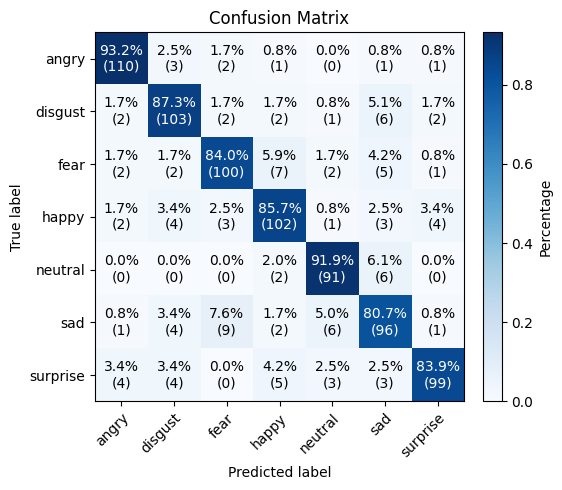

In [7]:
best_model = load('svm_ERT.joblib')
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

       angry       0.11      0.04      0.06       345
     disgust       0.03      0.19      0.05        68
        fear       0.02      0.56      0.03        50
       happy       0.09      0.00      0.01       402
     neutral       0.00      0.00      0.00      1256
         sad       0.08      0.06      0.07       208
    surprise       0.14      0.06      0.08       281

    accuracy                           0.03      2610
   macro avg       0.07      0.13      0.04      2610
weighted avg       0.05      0.03      0.03      2610



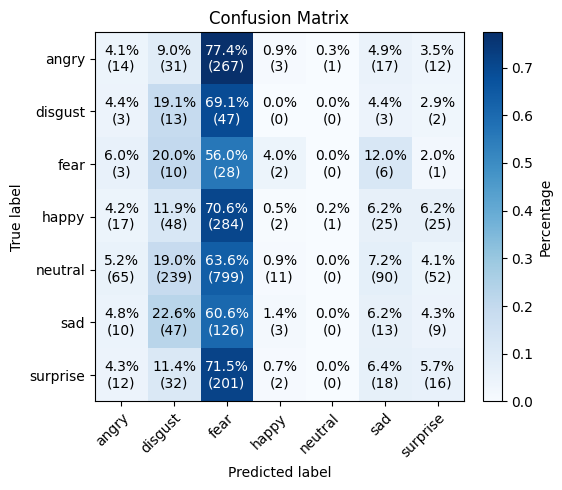

In [6]:
best_model = load('svm_ERT.joblib')
y_pred = best_model.predict(meld_feats)
print(classification_report(meld['label'], y_pred))
plot_confusion_matrix(meld['label'], y_pred)

              precision    recall  f1-score   support

       angry       0.71      0.01      0.02      1103
     disgust       0.00      0.50      0.00         2
        fear       0.02      0.50      0.03        40
       happy       0.12      0.08      0.10       595
     neutral       0.48      0.01      0.02      1708
         sad       0.44      0.47      0.45      1084
    surprise       0.05      0.33      0.09       107

    accuracy                           0.14      4639
   macro avg       0.26      0.27      0.10      4639
weighted avg       0.46      0.14      0.13      4639



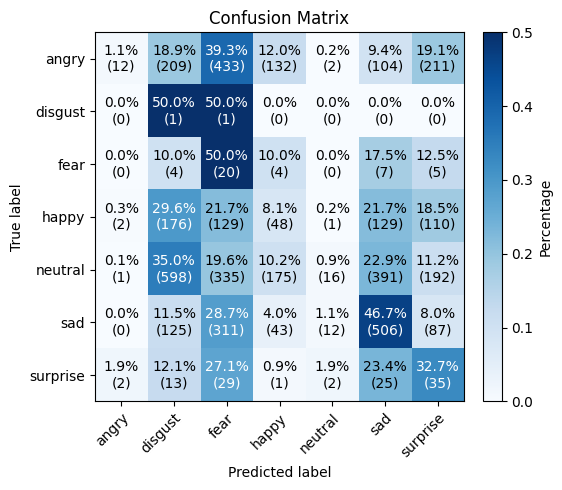

In [8]:
y_pred = best_model.predict(iemocap_feats)
print(classification_report(iemocap['label'], y_pred))
plot_confusion_matrix(iemocap['label'], y_pred)

## SVM - RAVDESS, TESS

In [ ]:


# SVM pipeline
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC()),
])

# Hyperparameter tuning
param_grid = {
    'svm__C': [0.1, 1, 10], #100
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto'],
}

# Leave-one-dataset-out cross-validation
datasets = {
    'IEMOCAP': (iemocap_feats, iemocap['label']),
    'EMODB': (emobd_feats, emodb['label']),
    'RAVDESS': (ravdess_feats, ravdess['label']),
    'TESS': (tess_feats, tess['label']),
    'CREMA-D': (crema_d_feats, crema_d['label']),
    #'MELD': (meld_feats, meld['label']),
}
#loo = LeaveOneGroupOut()

X = pd.concat([ravdess_feats, tess_feats])
y = pd.concat([ravdess['label'], tess['label']])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

grid_search = GridSearchCV(svm_pipeline, param_grid, cv=10, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_) 
print("Best cross-validation score:", grid_search.best_score_)
# save the best model
dump(grid_search.best_estimator_, 'svm_RT.joblib')

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.8s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.8s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.8s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.8s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.8s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.8s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.8s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.8s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.9s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   1.0s
[CV] END ....svm__C=0.1, svm__gamma=auto, svm__kernel=linear; total time=   0.9s
[CV] END ....svm__C=0.1, svm__gamma=auto, svm__kernel=linear; total time=   0.8s
[CV] END ......svm__C=0.1, s

['svm_RT.joblib']

              precision    recall  f1-score   support

       angry       0.91      0.93      0.92       118
     disgust       0.86      0.87      0.87       118
        fear       0.86      0.84      0.85       119
       happy       0.84      0.86      0.85       119
     neutral       0.88      0.92      0.90        99
         sad       0.80      0.81      0.80       119
    surprise       0.92      0.84      0.88       118

    accuracy                           0.87       810
   macro avg       0.87      0.87      0.87       810
weighted avg       0.87      0.87      0.87       810



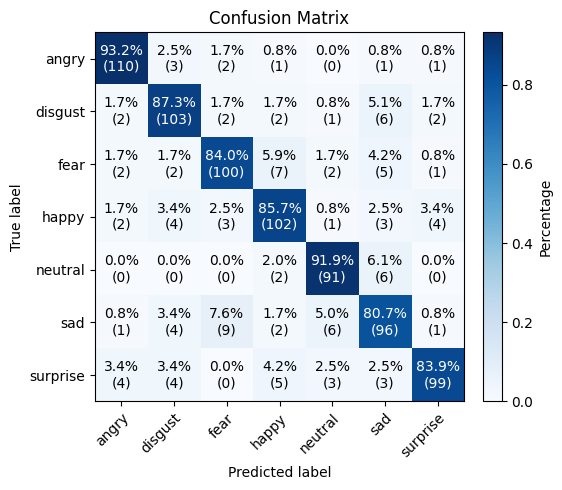

In [8]:
best_model = load('svm_RT.joblib')
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)


              precision    recall  f1-score   support

       angry       0.71      0.01      0.02      1103
     disgust       0.00      0.50      0.00         2
        fear       0.02      0.50      0.03        40
       happy       0.12      0.08      0.10       595
     neutral       0.48      0.01      0.02      1708
         sad       0.44      0.47      0.45      1084
    surprise       0.05      0.33      0.09       107

    accuracy                           0.14      4639
   macro avg       0.26      0.27      0.10      4639
weighted avg       0.46      0.14      0.13      4639



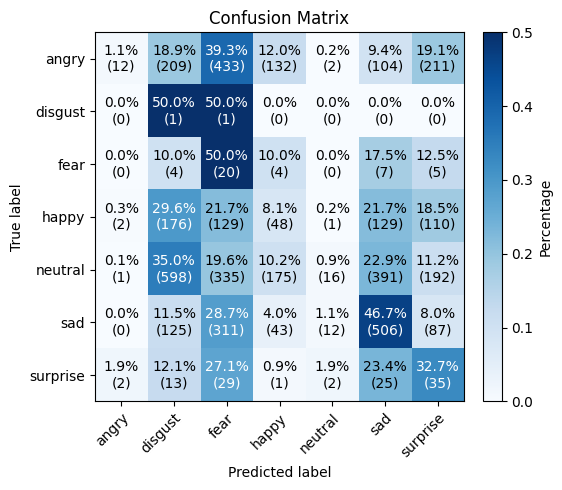

In [33]:
y_pred = best_model.predict(iemocap_feats)
print(classification_report(iemocap['label'], y_pred))
plot_confusion_matrix(iemocap['label'], y_pred)

              precision    recall  f1-score   support

       angry       0.11      0.04      0.06       345
     disgust       0.03      0.19      0.05        68
        fear       0.02      0.56      0.03        50
       happy       0.09      0.00      0.01       402
     neutral       0.00      0.00      0.00      1256
         sad       0.08      0.06      0.07       208
    surprise       0.14      0.06      0.08       281

    accuracy                           0.03      2610
   macro avg       0.07      0.13      0.04      2610
weighted avg       0.05      0.03      0.03      2610



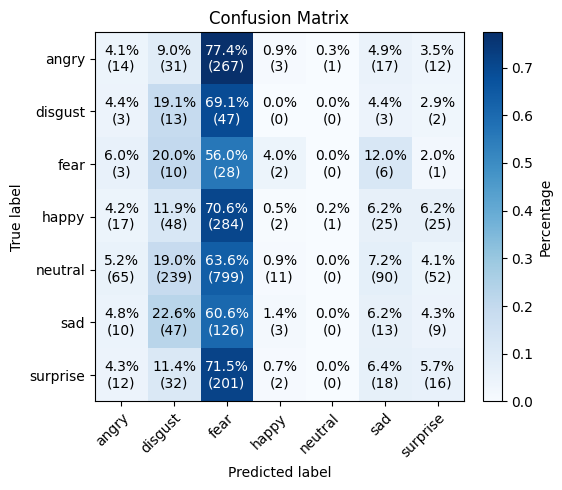

In [10]:
y_pred = best_model.predict(meld_feats)
print(classification_report(meld['label'], y_pred))
plot_confusion_matrix(meld['label'], y_pred)

## SVM - RAVDESS, TESS, CREMA-D

In [41]:
meld.label.value_counts()

label
neutral     1256
happy        402
angry        345
surprise     281
sad          208
disgust       68
fear          50
Name: count, dtype: int64

In [13]:
X = pd.concat([ravdess_feats, tess_feats, crema_d_feats])
y = pd.concat([ravdess['label'], tess['label'], crema_d['label']])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

grid_search = GridSearchCV(svm_pipeline, param_grid, cv=10, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_) 
print("Best cross-validation score:", grid_search.best_score_)
# save the best model
dump(grid_search.best_estimator_, 'svm_RTC.joblib')


Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  24.1s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  24.1s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  24.1s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  24.2s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  24.3s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  24.3s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  24.3s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  24.3s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  24.3s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  24.3s
[CV] END ......svm__C=0.1, svm__gamma=scale, svm__kernel=rbf; total time=  34.6s
[CV] END ......svm__C=0.1, svm__gamma=scale, s

['svm_RTC.joblib']

              precision    recall  f1-score   support

       angry       0.76      0.78      0.77       372
     disgust       0.56      0.51      0.53       372
        fear       0.57      0.59      0.58       373
       happy       0.60      0.56      0.58       373
     neutral       0.61      0.69      0.65       317
         sad       0.66      0.65      0.66       373
    surprise       0.94      0.90      0.92       118

    accuracy                           0.64      2298
   macro avg       0.67      0.67      0.67      2298
weighted avg       0.64      0.64      0.64      2298



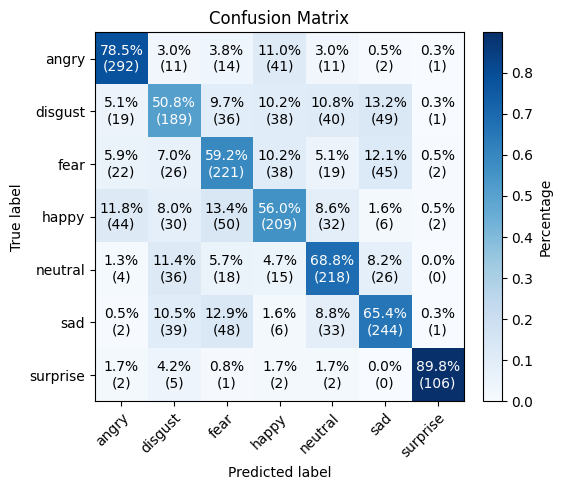

In [14]:
best_model = load('svm_RTC.joblib')
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

       angry       0.89      0.23      0.37      1103
     disgust       0.00      0.50      0.00         2
        fear       0.02      0.25      0.04        40
       happy       0.15      0.15      0.15       595
     neutral       0.64      0.16      0.26      1708
         sad       0.39      0.67      0.49      1084
    surprise       0.14      0.01      0.02       107

    accuracy                           0.29      4639
   macro avg       0.32      0.28      0.19      4639
weighted avg       0.56      0.29      0.32      4639



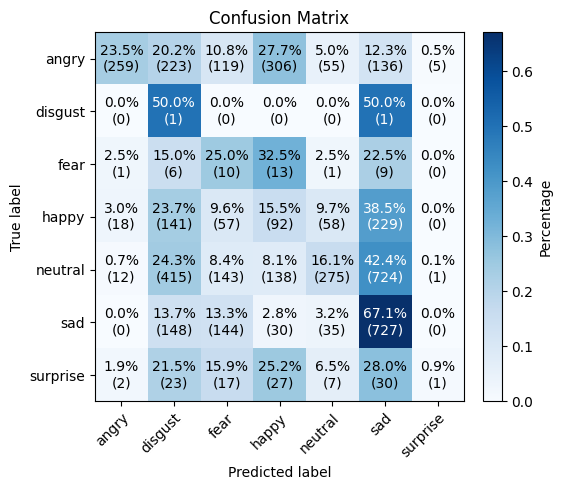

In [15]:
y_pred = best_model.predict(iemocap_feats)
print(classification_report(iemocap['label'], y_pred))
plot_confusion_matrix(iemocap['label'], y_pred)

              precision    recall  f1-score   support

       angry       0.14      0.09      0.11       345
     disgust       0.02      0.32      0.05        68
        fear       0.02      0.20      0.04        50
       happy       0.15      0.06      0.08       402
     neutral       0.67      0.01      0.02      1256
         sad       0.06      0.25      0.10       208
    surprise       0.15      0.01      0.02       281

    accuracy                           0.06      2610
   macro avg       0.17      0.13      0.06      2610
weighted avg       0.38      0.06      0.05      2610



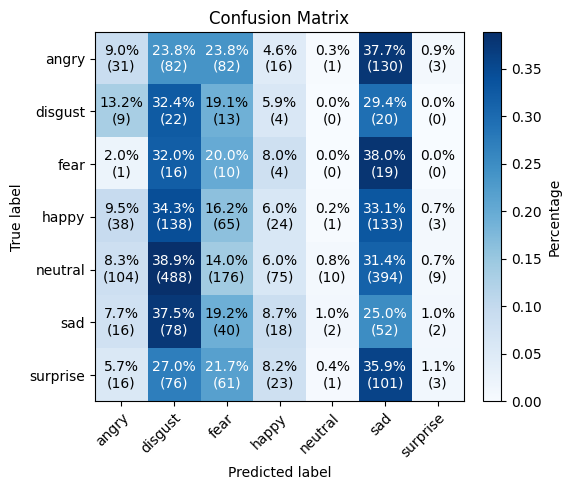

In [16]:
y_pred = best_model.predict(meld_feats)
print(classification_report(meld['label'], y_pred))
plot_confusion_matrix(meld['label'], y_pred)

## SVM - EmoDB, RAVDESS, TESS, CREMA-D, IEMOCAP --> MELD

In [17]:

X_train = pd.concat([emobd_feats, ravdess_feats, tess_feats, crema_d_feats, iemocap_feats])
y_train = pd.concat([emodb['label'], ravdess['label'], tess['label'], crema_d['label'], iemocap['label']])
X_test = meld_feats
y_test = meld['label']

grid_search = GridSearchCV(svm_pipeline, param_grid, cv=10, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_) 
print("Best cross-validation score:", grid_search.best_score_)
# save the best model
dump(grid_search.best_estimator_, 'svm_ERTCI.joblib')

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time= 1.2min
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time= 1.3min
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time= 1.3min
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time= 1.3min
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time= 1.3min
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time= 1.3min
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time= 1.3min
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time= 1.4min
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time= 1.4min
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time= 1.4min
[CV] END ......svm__C=0.1, svm__gamma=scale, svm__kernel=rbf; total time= 1.7min
[CV] END ......svm__C=0.1, svm__gamma=scale, s

['svm_ERTCI.joblib']

              precision    recall  f1-score   support

       angry       0.16      0.57      0.25       345
     disgust       0.02      0.01      0.02        68
        fear       0.00      0.00      0.00        50
       happy       0.15      0.09      0.11       402
     neutral       0.53      0.20      0.29      1256
         sad       0.07      0.19      0.10       208
    surprise       0.14      0.01      0.02       281

    accuracy                           0.20      2610
   macro avg       0.15      0.15      0.11      2610
weighted avg       0.32      0.20      0.20      2610



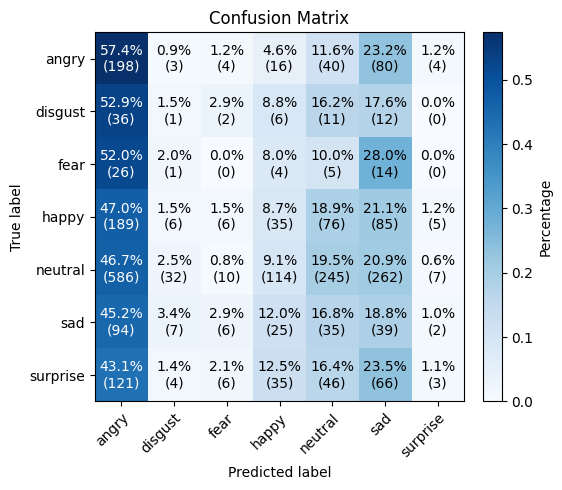

In [18]:
best_model = load('svm_ERTCI.joblib')
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

       angry       0.16      0.57      0.25       345
     disgust       0.02      0.01      0.02        68
        fear       0.00      0.00      0.00        50
       happy       0.15      0.09      0.11       402
     neutral       0.53      0.20      0.29      1256
         sad       0.07      0.19      0.10       208
    surprise       0.14      0.01      0.02       281

    accuracy                           0.20      2610
   macro avg       0.15      0.15      0.11      2610
weighted avg       0.32      0.20      0.20      2610



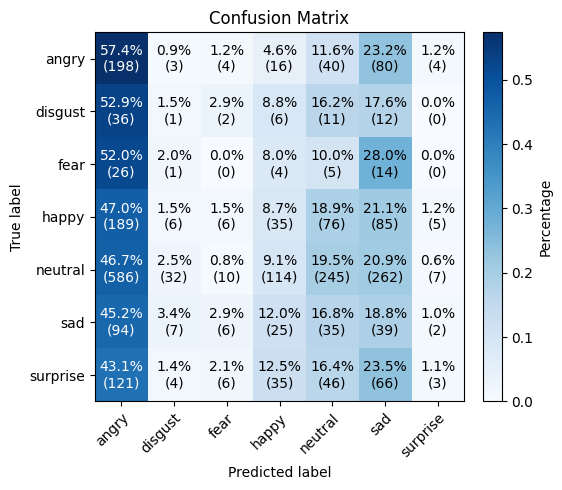

In [34]:
# meld
best_model = load('svm_ERTCI.joblib')
y_pred = best_model.predict(meld_feats)
print(classification_report(meld['label'], y_pred))
plot_confusion_matrix(meld['label'], y_pred)

## SVM - EmoDB, RAVDESS, TESS, CREMA-D --> MELD

In [ ]:

X_train = pd.concat([emobd_feats, ravdess_feats, tess_feats, crema_d_feats])
y_train = pd.concat([emodb['label'], ravdess['label'], tess['label'], crema_d['label']])
X_test = iemocap_feats
y_test = iemocap['label']

grid_search = GridSearchCV(svm_pipeline, param_grid, cv=10, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_) 
print("Best cross-validation score:", grid_search.best_score_)
# save the best model
dump(grid_search.best_estimator_, 'svm_ERTC.joblib')

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  32.4s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  33.8s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  33.8s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  34.2s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  34.3s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  34.5s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  34.9s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  36.1s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  36.8s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  38.1s
[CV] END ......svm__C=0.1, svm__gamma=scale, svm__kernel=rbf; total time=  48.8s
[CV] END ......svm__C=0.1, svm__gamma=scale, s

['svm_ERTC.joblib']

              precision    recall  f1-score   support

       angry       0.88      0.27      0.41      1103
     disgust       0.00      0.50      0.00         2
        fear       0.02      0.25      0.04        40
       happy       0.13      0.12      0.13       595
     neutral       0.59      0.16      0.25      1708
         sad       0.40      0.68      0.50      1084
    surprise       0.12      0.02      0.03       107

    accuracy                           0.30      4639
   macro avg       0.31      0.28      0.19      4639
weighted avg       0.54      0.30      0.32      4639



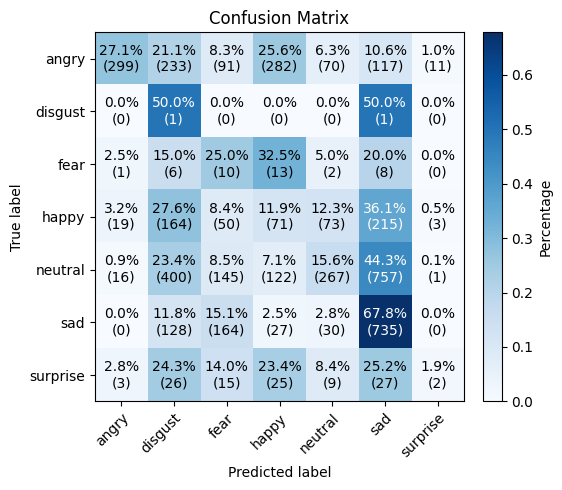

In [11]:
best_model = load('svm_ERTC.joblib')
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)


              precision    recall  f1-score   support

       angry       0.17      0.18      0.17       345
     disgust       0.03      0.32      0.05        68
        fear       0.02      0.16      0.04        50
       happy       0.20      0.05      0.08       402
     neutral       0.59      0.02      0.03      1256
         sad       0.07      0.33      0.12       208
    surprise       0.18      0.01      0.03       281

    accuracy                           0.08      2610
   macro avg       0.18      0.15      0.08      2610
weighted avg       0.36      0.08      0.07      2610



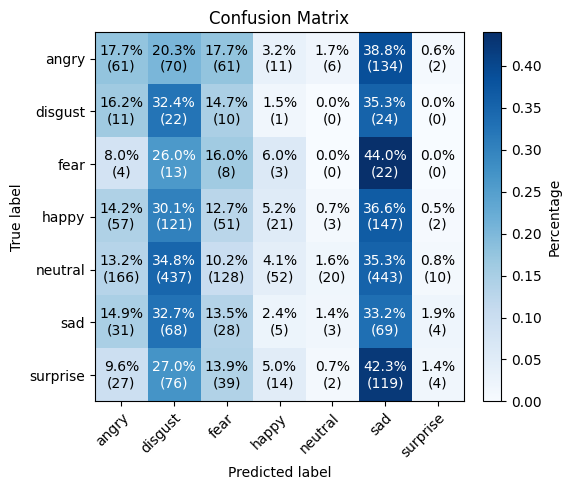

In [35]:
# meld
best_model = load('svm_ERTC.joblib')
y_pred = best_model.predict(meld_feats)
print(classification_report(meld['label'], y_pred))
plot_confusion_matrix(meld['label'], y_pred)

## SVM - EmoDB, RAVDESS, CREMA-D

In [12]:
X_train = pd.concat([emobd_feats, ravdess_feats, crema_d_feats])
y_train = pd.concat([emodb['label'], ravdess['label'], crema_d['label']])
X_test = tess_feats
y_test = tess['label']

grid_search = GridSearchCV(svm_pipeline, param_grid, cv=10, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_) 
print("Best cross-validation score:", grid_search.best_score_)
# save the best model
dump(grid_search.best_estimator_, 'svm_ERC.joblib')

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  25.9s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  26.5s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  26.7s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  26.7s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  26.7s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  26.8s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  26.8s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  26.9s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  27.1s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=  27.2s
[CV] END ......svm__C=0.1, svm__gamma=scale, svm__kernel=rbf; total time=  37.2s
[CV] END ......svm__C=0.1, svm__gamma=scale, s

['svm_ERC.joblib']

/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

              precision    recall  f1-score   support

       angry       0.31      0.12      0.18       400
     disgust       0.25      0.69      0.37       400
        fear       0.40      0.03      0.06       400
       happy       0.23      0.22      0.22       400
     neutral       0.00      0.00      0.00       400
         sad       0.31      0.84      0.45       400
    surprise       0.00      0.00      0.00       400

    accuracy                           0.27      2800
   macro avg       0.21      0.27      0.18      2800
weighted avg       0.21      0.27      0.18      2800



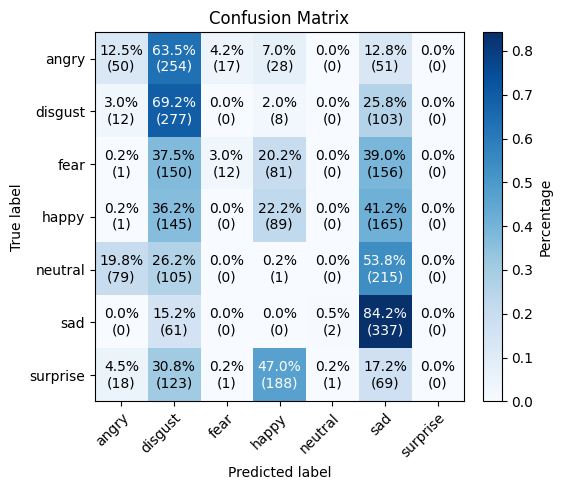

In [13]:
best_model = load('svm_ERC.joblib')
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

       angry       0.86      0.27      0.41      1103
     disgust       0.00      0.00      0.00         2
        fear       0.01      0.15      0.03        40
       happy       0.13      0.11      0.12       595
     neutral       0.52      0.09      0.15      1708
         sad       0.36      0.71      0.48      1084
    surprise       0.40      0.02      0.04       107

    accuracy                           0.28      4639
   macro avg       0.33      0.19      0.17      4639
weighted avg       0.51      0.28      0.28      4639



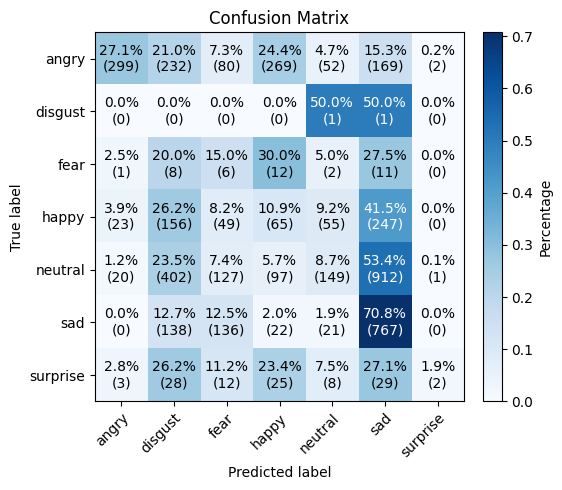

In [14]:
y_pred = best_model.predict(iemocap_feats)
print(classification_report(iemocap['label'], y_pred))
plot_confusion_matrix(iemocap['label'], y_pred)

              precision    recall  f1-score   support

       angry       0.17      0.15      0.16       345
     disgust       0.03      0.28      0.05        68
        fear       0.01      0.04      0.02        50
       happy       0.17      0.13      0.15       402
     neutral       0.64      0.01      0.02      1256
         sad       0.07      0.36      0.11       208
    surprise       0.00      0.00      0.00       281

    accuracy                           0.08      2610
   macro avg       0.15      0.14      0.07      2610
weighted avg       0.36      0.08      0.07      2610



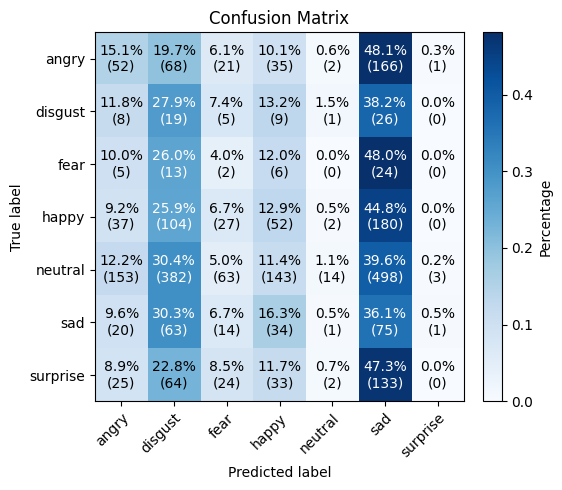

In [36]:
# meld
best_model = load('svm_ERC.joblib')
y_pred = best_model.predict(meld_feats)
print(classification_report(meld['label'], y_pred))
plot_confusion_matrix(meld['label'], y_pred)

## Random Forest - EmoDB, RAVDESS, CREMA-D, TESS, IEMOCAP

In [ ]:
# Grid search with Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier()),
])
grid_param = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
}


X_train = pd.concat([emobd_feats, ravdess_feats, tess_feats, crema_d_feats, iemocap_feats])
y_train = pd.concat([emodb['label'], ravdess['label'], tess['label'], crema_d['label'], iemocap['label']])
X_test = meld_feats
y_test = meld['label']

grid_search_rf = GridSearchCV(rf_pipeline, grid_param, cv=10, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)
print("Best parameters (RF):", grid_search_rf.best_params_) 
print("Best cross-validation score (RF):", grid_search_rf.best_score_)
dump(grid_search_rf.best_estimator_, 'rf_ERCTI.joblib')

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  27.8s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  28.0s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  28.0s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  28.1s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  28.1s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  28.1s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  28.1s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; tota

['rf_ERCTI.joblib']

              precision    recall  f1-score   support

       angry       0.16      0.74      0.26       345
     disgust       0.02      0.01      0.02        68
        fear       0.05      0.04      0.04        50
       happy       0.17      0.06      0.09       402
     neutral       0.53      0.30      0.38      1256
         sad       0.12      0.03      0.05       208
    surprise       0.12      0.01      0.01       281

    accuracy                           0.25      2610
   macro avg       0.17      0.17      0.12      2610
weighted avg       0.33      0.25      0.24      2610



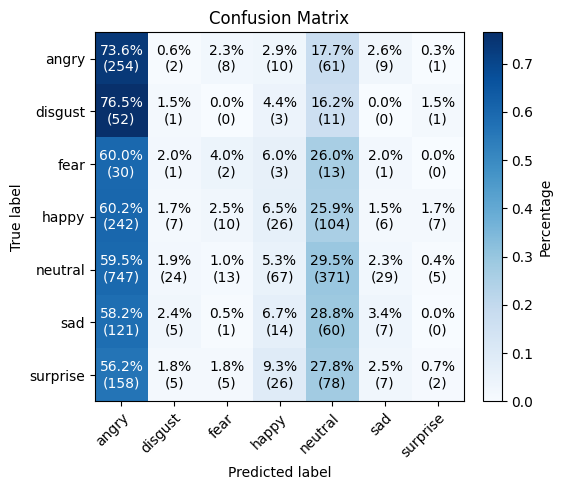

In [20]:
best_model = load('rf_ERCTI.joblib')
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

       angry       0.16      0.74      0.26       345
     disgust       0.02      0.01      0.02        68
        fear       0.05      0.04      0.04        50
       happy       0.17      0.06      0.09       402
     neutral       0.53      0.30      0.38      1256
         sad       0.12      0.03      0.05       208
    surprise       0.12      0.01      0.01       281

    accuracy                           0.25      2610
   macro avg       0.17      0.17      0.12      2610
weighted avg       0.33      0.25      0.24      2610



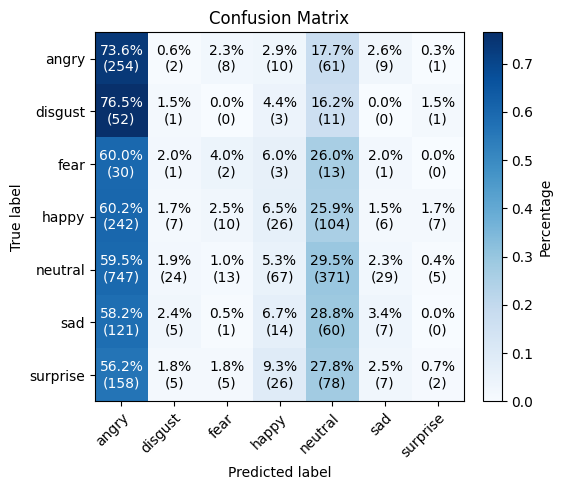

In [38]:
# meld
best_model = load('rf_ERCTI.joblib')
y_pred = best_model.predict(meld_feats)
print(classification_report(meld['label'], y_pred))
plot_confusion_matrix(meld['label'], y_pred)

## SVM - EmoDB, RAVDESS, CREMA-D, TESS

In [ ]:
X_train = pd.concat([emobd_feats, ravdess_feats, tess_feats, crema_d_feats])
y_train = pd.concat([emodb['label'], ravdess['label'], tess['label'], crema_d['label']])
X_test = meld_feats
y_test = meld['label']

grid_search_rf = GridSearchCV(rf_pipeline, grid_param, cv=10, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)
print("Best parameters (RF):", grid_search_rf.best_params_) 
print("Best cross-validation score (RF):", grid_search_rf.best_score_)
dump(grid_search_rf.best_estimator_, 'rf_ERCT.joblib')

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  19.1s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  19.2s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  19.3s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  19.3s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  19.4s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  19.4s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  19.5s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; tota

['rf_ERCT.joblib']

              precision    recall  f1-score   support

       angry       0.15      0.52      0.23       345
     disgust       0.02      0.21      0.04        68
        fear       0.03      0.10      0.04        50
       happy       0.16      0.07      0.10       402
     neutral       0.54      0.05      0.09      1256
         sad       0.11      0.08      0.09       208
    surprise       0.20      0.06      0.10       281

    accuracy                           0.12      2610
   macro avg       0.17      0.16      0.10      2610
weighted avg       0.33      0.12      0.11      2610



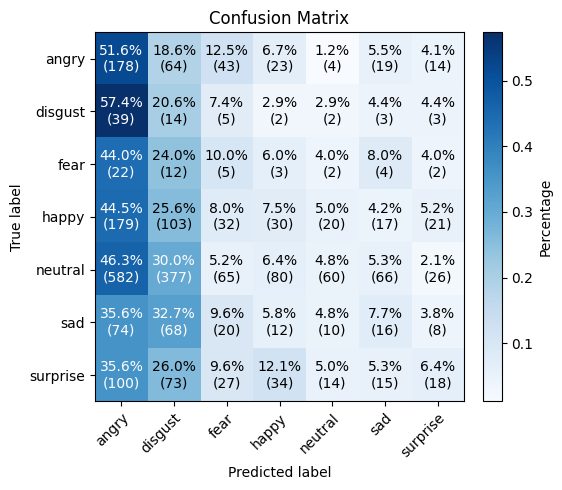

In [22]:
best_model = load('rf_ERCT.joblib')
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

       angry       0.15      0.52      0.23       345
     disgust       0.02      0.21      0.04        68
        fear       0.03      0.10      0.04        50
       happy       0.16      0.07      0.10       402
     neutral       0.54      0.05      0.09      1256
         sad       0.11      0.08      0.09       208
    surprise       0.20      0.06      0.10       281

    accuracy                           0.12      2610
   macro avg       0.17      0.16      0.10      2610
weighted avg       0.33      0.12      0.11      2610



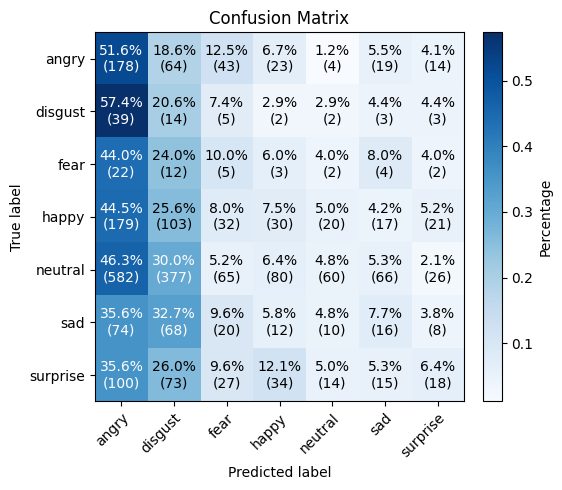

In [39]:
# meld
best_model = load('rf_ERCT.joblib')
y_pred = best_model.predict(meld_feats)
print(classification_report(meld['label'], y_pred))
plot_confusion_matrix(meld['label'], y_pred)

## LogReg - EmoDB, RAVDESS, CREMA-D, TESS

In [23]:
# logistic regression
from sklearn.linear_model import LogisticRegression
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=5000)),
])
grid_param = {
    'logreg__C': [0.1, 1, 10],
    'logreg__penalty': ['l2'],
    'logreg__solver': ['lbfgs', 'saga'],
}

X_train = pd.concat([emobd_feats, ravdess_feats, tess_feats, crema_d_feats])
y_train = pd.concat([emodb['label'], ravdess['label'], tess['label'], crema_d['label']])
X_test = meld_feats
y_test = meld['label']
grid_search_logreg = GridSearchCV(logreg_pipeline, grid_param, cv=10, n_jobs=-1, verbose=2)
grid_search_logreg.fit(X_train, y_train)
print("Best parameters (LogReg):", grid_search_logreg.best_params_) 
print("Best cross-validation score (LogReg):", grid_search_logreg.best_score_)
dump(grid_search_logreg.best_estimator_, 'logreg_ERTC.joblib')

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   2.1s
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   2.2s
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   2.2s
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   2.2s
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   2.2s
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   2.3s
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   2.3s
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   2.4s
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   2.4s
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   2.4s
[CV] END logreg__C=1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   5.1s
[CV] E

['logreg_ERTC.joblib']

              precision    recall  f1-score   support

       angry       0.19      0.15      0.17       345
     disgust       0.03      0.54      0.05        68
        fear       0.02      0.06      0.02        50
       happy       0.16      0.07      0.10       402
     neutral       0.57      0.09      0.15      1256
         sad       0.12      0.08      0.09       208
    surprise       0.15      0.17      0.16       281

    accuracy                           0.11      2610
   macro avg       0.18      0.17      0.11      2610
weighted avg       0.35      0.11      0.14      2610



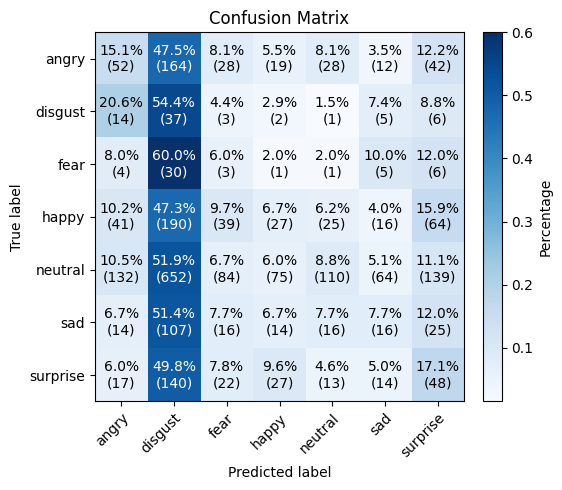

In [25]:
best_model = load('logreg_ERTC.joblib')
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

       angry       0.19      0.15      0.17       345
     disgust       0.03      0.54      0.05        68
        fear       0.02      0.06      0.02        50
       happy       0.16      0.07      0.10       402
     neutral       0.57      0.09      0.15      1256
         sad       0.12      0.08      0.09       208
    surprise       0.15      0.17      0.16       281

    accuracy                           0.11      2610
   macro avg       0.18      0.17      0.11      2610
weighted avg       0.35      0.11      0.14      2610



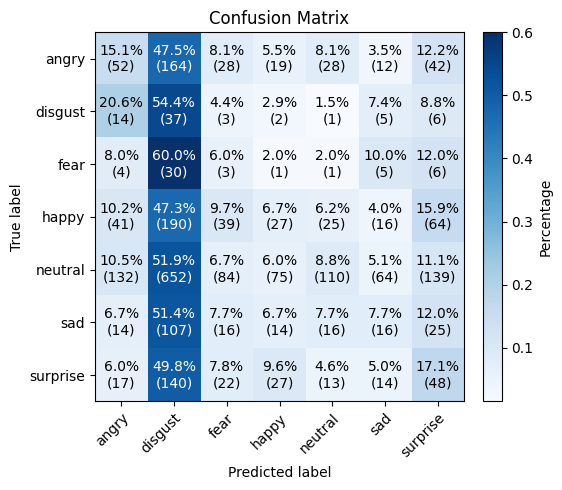

In [40]:
# meld
best_model = load('logreg_ERTC.joblib')
y_pred = best_model.predict(meld_feats)
print(classification_report(meld['label'], y_pred))
plot_confusion_matrix(meld['label'], y_pred)

In [26]:
X_train = pd.concat([emobd_feats, ravdess_feats, tess_feats, crema_d_feats, iemocap_feats])
y_train = pd.concat([emodb['label'], ravdess['label'], tess['label'], crema_d['label'], iemocap['label']])
X_test = meld_feats
y_test = meld['label']
grid_search_logreg = GridSearchCV(logreg_pipeline, grid_param, cv=10, n_jobs=-1, verbose=2)
grid_search_logreg.fit(X_train, y_train)
print("Best parameters (LogReg):", grid_search_logreg.best_params_) 
print("Best cross-validation score (LogReg):", grid_search_logreg.best_score_)
dump(grid_search_logreg.best_estimator_, 'logreg_ERTCI.joblib')

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   3.2s
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   3.3s
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   3.3s
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   3.4s
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   3.4s
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   3.4s
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   3.6s
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   3.6s
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   3.6s
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   3.7s
[CV] END logreg__C=1, logreg__penalty=l2, logreg__solver=lbfgs; total time=  12.2s
[CV] E

/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logreg__C=10, logreg__penalty=l2, logreg__solver=saga; total time=10.7min


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logreg__C=10, logreg__penalty=l2, logreg__solver=saga; total time= 9.7min


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logreg__C=10, logreg__penalty=l2, logreg__solver=saga; total time= 9.4min
[CV] END logreg__C=10, logreg__penalty=l2, logreg__solver=saga; total time= 8.9min


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logreg__C=10, logreg__penalty=l2, logreg__solver=saga; total time= 9.3min


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logreg__C=10, logreg__penalty=l2, logreg__solver=saga; total time= 9.2min
[CV] END logreg__C=10, logreg__penalty=l2, logreg__solver=saga; total time= 9.1min


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END logreg__C=10, logreg__penalty=l2, logreg__solver=saga; total time= 9.1min
[CV] END logreg__C=10, logreg__penalty=l2, logreg__solver=saga; total time= 9.1min
Best parameters (LogReg): {'logreg__C': 10, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}
Best cross-validation score (LogReg): 0.4766343030776311


['logreg_ERTCI.joblib']

              precision    recall  f1-score   support

       angry       0.16      0.32      0.21       345
     disgust       0.03      0.24      0.05        68
        fear       0.01      0.08      0.02        50
       happy       0.14      0.11      0.12       402
     neutral       0.52      0.13      0.21      1256
         sad       0.11      0.08      0.09       208
    surprise       0.16      0.11      0.13       281

    accuracy                           0.15      2610
   macro avg       0.16      0.15      0.12      2610
weighted avg       0.32      0.15      0.17      2610



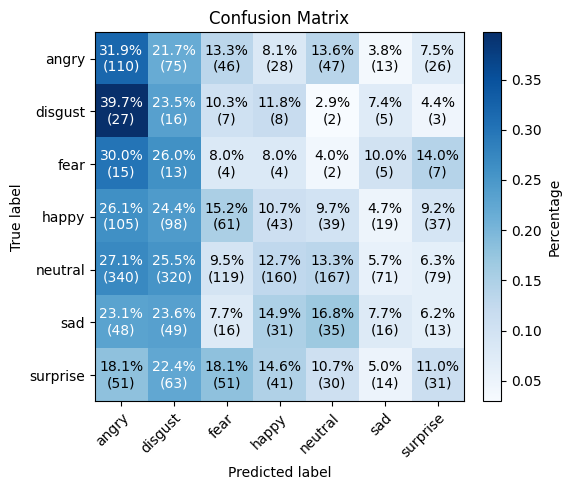

In [28]:
best_model = load('logreg_ERTCI.joblib')
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)

In [15]:
# Grid search with Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier()),
])
grid_param = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
}

grid_search_rf = GridSearchCV(rf_pipeline, grid_param, cv=10, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)
print("Best parameters (RF):", grid_search_rf.best_params_) 
print("Best cross-validation score (RF):", grid_search_rf.best_score_)
dump(grid_search_rf.best_estimator_, 'rf_ERC.joblib')

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  14.1s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  14.2s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  14.2s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  14.2s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  14.2s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  14.2s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  14.3s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; tota

['rf_ERC.joblib']

/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

              precision    recall  f1-score   support

       angry       0.44      0.21      0.29       400
     disgust       0.43      0.62      0.50       400
        fear       0.70      0.47      0.56       400
       happy       0.26      0.72      0.38       400
     neutral       0.05      0.02      0.03       400
         sad       0.40      0.49      0.44       400
    surprise       0.00      0.00      0.00       400

    accuracy                           0.36      2800
   macro avg       0.32      0.36      0.31      2800
weighted avg       0.32      0.36      0.31      2800



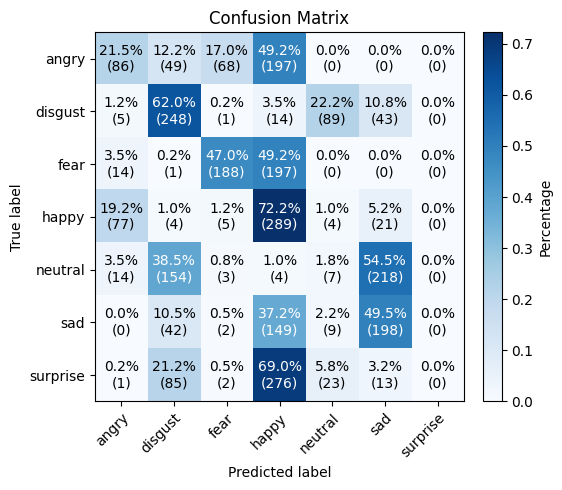

In [16]:
best_model = load('rf_ERC.joblib')
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)

/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

              precision    recall  f1-score   support

       angry       0.79      0.40      0.53      1103
     disgust       0.00      0.50      0.00         2
        fear       0.04      0.23      0.07        40
       happy       0.15      0.16      0.16       595
     neutral       0.65      0.23      0.34      1708
         sad       0.45      0.76      0.57      1084
    surprise       0.00      0.00      0.00       107

    accuracy                           0.38      4639
   macro avg       0.30      0.33      0.24      4639
weighted avg       0.55      0.38      0.40      4639



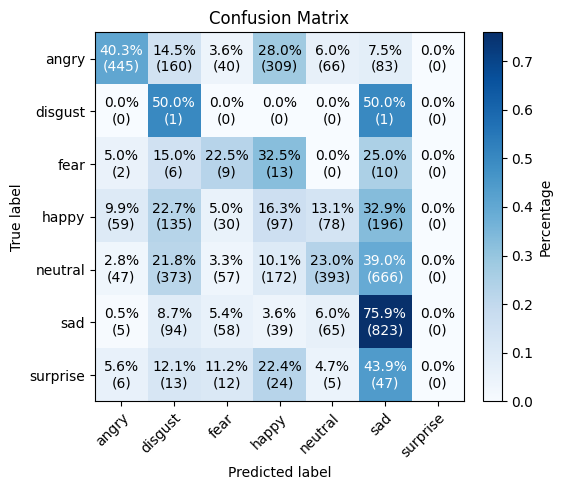

In [17]:
y_pred = best_model.predict(iemocap_feats)
print(classification_report(iemocap['label'], y_pred))
plot_confusion_matrix(iemocap['label'], y_pred)

In [25]:
# grid search naive bayes
from sklearn.naive_bayes import GaussianNB
gnb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('gnb', GaussianNB()),
])
grid_param = {
    'gnb__var_smoothing': [1e-9, 1e-8, 1e-7],
}
grid_search_gnb = GridSearchCV(gnb_pipeline, grid_param, cv=10, n_jobs=-1, verbose=2)
grid_search_gnb.fit(X_train, y_train)
print("Best parameters (GNB):", grid_search_gnb.best_params_) 
print("Best cross-validation score (GNB):", grid_search_gnb.best_score_)
dump(grid_search_gnb.best_estimator_, 'gnb_ERC.joblib')

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] END ...........................gnb__var_smoothing=1e-08; total time=   0.1s
[CV] END ...........................gnb__var_smoothing=1e-09; total time=   0.1s
[CV] END ...........................gnb__var_smoothing=1e-09; total time=   0.1s
[CV] END ...........................gnb__var_smoothing=1e-08; total time=   0.1s
[CV] END ...........................gnb__var_smoothing=1e-09; total time=   0.1s
[CV] END ...........................gnb__var_smoothing=1e-09; total time=   0.1s
[CV] END ...........................gnb__var_smoothing=1e-09; total time=   0.1s
[CV] END ...........................gnb__var_smoothing=1e-09; total time=   0.1s
[CV] END ...........................gnb__var_smoothing=1e-09; total time=   0.1s
[CV] END ...........................gnb__var_smoothing=1e-09; total time=   0.1s
[CV] END ...........................gnb__var_smoothing=1e-09; total time=   0.1s
[CV] END ...........................gnb__var_smo

['gnb_ERC.joblib']

## Logistic Regression

In [29]:
# logistic regression
from sklearn.linear_model import LogisticRegression
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=5000)),
])
grid_param = {
    'logreg__C': [0.1, 1, 10],
    'logreg__penalty': ['l2'],
    'logreg__solver': ['lbfgs', 'saga'],
}
grid_search_logreg = GridSearchCV(logreg_pipeline, grid_param, cv=10, n_jobs=-1, verbose=2)
grid_search_logreg.fit(X_train, y_train)
print("Best parameters (LogReg):", grid_search_logreg.best_params_) 
print("Best cross-validation score (LogReg):", grid_search_logreg.best_score_)
dump(grid_search_logreg.best_estimator_, 'logreg_ERC.joblib')

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   1.6s
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   1.6s
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   1.7s
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   1.7s
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   1.6s
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   1.6s
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   1.7s
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   1.7s
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   1.7s
[CV] END logreg__C=0.1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   1.9s
[CV] END logreg__C=1, logreg__penalty=l2, logreg__solver=lbfgs; total time=   2.7s
[CV] E

['logreg_ERC.joblib']

              precision    recall  f1-score   support

       angry       0.45      0.24      0.31       400
     disgust       0.23      0.64      0.34       400
        fear       0.05      0.03      0.04       400
       happy       0.29      0.23      0.26       400
     neutral       0.53      0.71      0.61       400
         sad       0.13      0.14      0.13       400
    surprise       0.00      0.00      0.00       400

    accuracy                           0.28      2800
   macro avg       0.24      0.28      0.24      2800
weighted avg       0.24      0.28      0.24      2800



/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

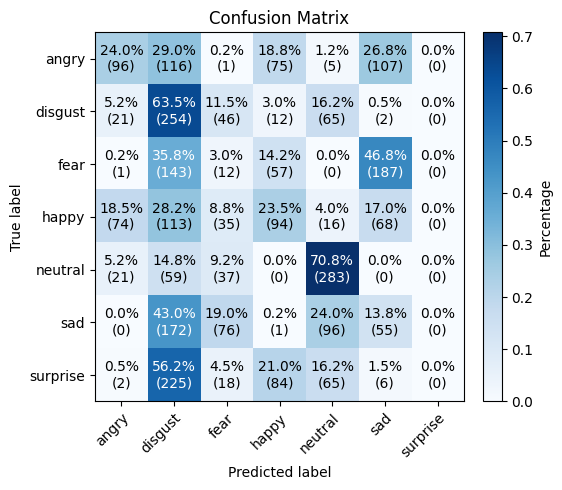

In [30]:
best_model = load('logreg_ERC.joblib')
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

       angry       0.89      0.29      0.43      1103
     disgust       0.00      0.00      0.00         2
        fear       0.07      0.28      0.11        40
       happy       0.18      0.10      0.13       595
     neutral       0.61      0.30      0.40      1708
         sad       0.46      0.68      0.55      1084
    surprise       0.22      0.04      0.06       107

    accuracy                           0.35      4639
   macro avg       0.35      0.24      0.24      4639
weighted avg       0.57      0.35      0.40      4639



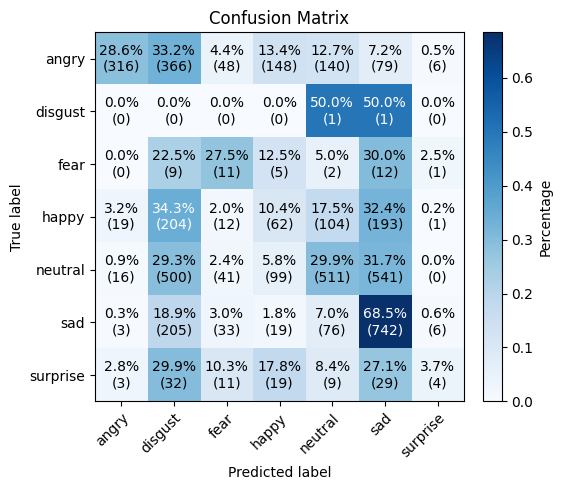

In [31]:
y_pred = best_model.predict(iemocap_feats)
print(classification_report(iemocap['label'], y_pred))
plot_confusion_matrix(iemocap['label'], y_pred)

## XGBoost

In [22]:
# grid search XGBoost
from xgboost import XGBClassifier
#label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)   
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
])
xgb_param = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 6],
    'xgb__learning_rate': [0.01, 0.1],
}
grid_search_xgb = GridSearchCV(xgb_pipeline, xgb_param, cv=10, n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, y_train_enc)
print("Best parameters (XGB):", grid_search_xgb.best_params_) 
print("Best cross-validation score (XGB):", grid_search_xgb.best_score_)
dump(grid_search_xgb.best_estimator_, 'xgb_ERC.joblib')

Fitting 10 folds for each of 8 candidates, totalling 80 fits


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:00:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:00:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:00:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:00:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use

[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   7.5s
[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   7.6s
[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   7.6s
[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   7.6s
[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   7.6s
[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   7.7s
[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   7.7s
[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   7.6s
[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   7.7s
[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   7.7s


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:01:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:01:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:01:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:01:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use

[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200; total time=  14.8s
[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200; total time=  14.8s


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:01:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:01:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200; total time=  14.5s
[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200; total time=  14.5s
[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200; total time=  14.6s
[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200; total time=  14.6s
[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200; total time=  14.6s
[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200; total time=  14.7s
[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200; total time=  14.8s
[CV] END xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200; total time=  14.7s


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:01:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:01:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:01:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:01:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use

[CV] END xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=  33.3s


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:01:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=  34.0s


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:01:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=  35.6s
[CV] END xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=  35.8s


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:01:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:01:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=  36.7s


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:01:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=  37.3s
[CV] END xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=  37.4s
[CV] END xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=  37.5s


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:01:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:01:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:01:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=  37.8s
[CV] END xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=  38.1s


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:01:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:01:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   7.5s


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:02:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   7.6s


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:02:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   7.4s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   7.3s


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:02:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:02:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   7.3s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   7.3s


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:02:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:02:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   7.3s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   7.3s


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:02:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:02:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=200; total time= 1.2min


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:02:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=200; total time= 1.2min


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:02:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   7.5s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   7.5s


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:02:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:02:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200; total time=  14.2s


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:02:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200; total time=  14.3s


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:02:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=200; total time= 1.2min
[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200; total time=  14.1s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200; total time=  14.2s


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:02:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:02:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:02:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=200; total time= 1.2min


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:02:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=200; total time= 1.2min


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:02:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=200; total time= 1.2min


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:02:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200; total time=  15.4s


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:02:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200; total time=  15.5s


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:03:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200; total time=  16.6s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200; total time=  16.7s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200; total time=  16.6s


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:03:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:03:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:03:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=200; total time= 1.2min
[CV] END xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=200; total time=  16.7s
[CV] END xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=200; total time= 1.2min
[CV] END xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=200; total time= 1.2min


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:03:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:03:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:03:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:03:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use

[CV] END xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=200; total time= 1.2min


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:03:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=  32.0s


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:03:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=  32.3s


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:03:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=  32.0s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=  31.6s


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:03:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:03:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=  30.6s


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:03:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=  30.8s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=  31.1s


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:03:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:03:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=  30.5s


/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:03:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=  31.2s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=  31.1s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=200; total time=  54.5s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=200; total time=  54.3s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=200; total time=  47.8s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=200; total time=  46.5s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=200; total time=  47.3s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=200; total time=  46.7s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=200; total time=  44.1s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=200; total time=  43.6s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=2

/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:04:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters (XGB): {'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 200}
Best cross-validation score (XGB): 0.5065802154703399


['xgb_ERC.joblib']

/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

              precision    recall  f1-score   support

           0       0.36      0.07      0.11       400
           1       0.26      0.81      0.40       400
           2       0.66      0.18      0.29       400
           3       0.20      0.34      0.25       400
           4       0.26      0.06      0.10       400
           5       0.36      0.54      0.43       400
           6       0.00      0.00      0.00       400

    accuracy                           0.29      2800
   macro avg       0.30      0.29      0.23      2800
weighted avg       0.30      0.29      0.23      2800



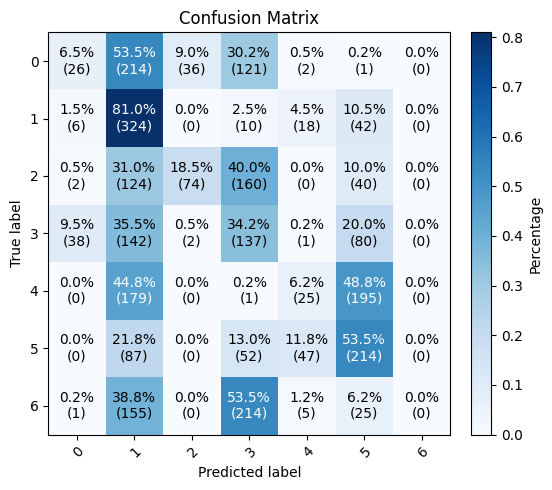

In [24]:
best_model = load('xgb_ERC.joblib')
y_pred = best_model.predict(X_test)
print(classification_report(y_test_enc, y_pred))
plot_confusion_matrix(y_test_enc, y_pred)

## Feature Selection


**2. eGeMAPS:**
* **What it is:** eGeMAPS is a carefully selected set of 88 acoustic features designed to capture essential paralinguistic information related to emotion. It's based on extensive research in affective computing and aims for a compact yet informative representation of the speech signal.
* **Characteristics:**
    * **Low dimensionality:** 88 features per time frame. This can lead to faster training and potentially require less data for the models to generalize.
    * **Emotionally relevant:** The features are specifically chosen for their known correlation with emotional states.
    * **Interpretability:** Some of the features have relatively clear psychoacoustic interpretations (e.g., fundamental frequency, jitter, shimmer, energy-related features, spectral slope).
* **When to consider it for DL:**
    * **Smaller datasets:** The lower dimensionality might be advantageous when you have a limited amount of training data, as it reduces the risk of overfitting.
    * **Focus on paralinguistic cues:** If you believe that the emotional content is primarily conveyed through these higher-level acoustic characteristics.
    * **Faster experimentation:** The smaller input size can lead to quicker training times, allowing for more rapid iteration.

**2. Full Acoustic Feature Set (librosa - often including MFCCs):**

* **What it is:** This typically involves extracting a wide range of acoustic features using a library like `librosa`. A very common and powerful component of this set is Mel-Frequency Cepstral Coefficients (MFCCs).
* **Mel-Frequency Cepstral Coefficients (MFCCs):**
    * **What they are:** MFCCs are a compact representation of the spectral envelope of a speech signal, mimicking the human auditory system's perception of frequencies. They are derived by taking the Fourier transform of short segments of the audio, mapping the powers of these frequencies onto the mel scale (a perceptual scale of pitches), taking the logarithm of these mel-scaled powers, and then taking the discrete cosine transform (DCT) of the list of mel log powers.
    * **Characteristics:** MFCCs capture the short-term power spectrum of the sound, which is highly relevant for phonetic content and also carries emotional information. The number of MFCCs typically ranges from 13 to 40.
* **Other features in a "full" set (from librosa):** Besides MFCCs, `librosa` can extract a plethora of other features, including:
    * **Spectral features:** Spectral centroid, spectral bandwidth, spectral contrast, spectral flatness, spectral roll-off.
    * **Temporal features:** Zero-crossing rate, root-mean-square (RMS) energy.
    * **Chromagram:** Representation of the spectral energy distribution over 12 pitch classes.
    * **And many more.**
* **Characteristics of the full set:**
    * **High dimensionality:** Combining MFCCs (e.g., 20-40 coefficients per frame) with other spectral and temporal features can result in a significantly higher-dimensional input compared to GeMAPS.
    * **Rich information:** This set captures a broader range of acoustic characteristics, potentially including subtle cues that GeMAPS might miss.
    * **Potentially better performance (with enough data):** With sufficient training data, the richer input can allow deep learning models to learn more complex patterns and achieve higher accuracy.
* **When to consider it for DL:**
    * **Larger datasets:** Deep learning models thrive on large amounts of data to learn complex relationships in high-dimensional spaces.
    * **Potential for higher accuracy:** The comprehensive feature set might capture more nuanced emotional information.
    * **Flexibility for the model:** The neural network can learn to weigh the importance of different features within the set.

## Input for Your Deep Learning Architectures: Detailed Explanation

Now, let's specifically address how you would use these features as input for your CNN, RNN, and Hybrid models:

**1. Convolutional Neural Networks (CNNs):**

* **Input format:** CNNs are typically designed to process grid-like data. For audio, this often translates to a 2D representation of the features over time.
* **How to prepare the input:**
    * **Frame-based extraction:** Extract your chosen feature set (GeMAPS or the full set) for short, overlapping frames of the audio signal. This will give you a sequence of feature vectors over time.
    * **Creating the 2D input:** Stack these feature vectors as rows to form a 2D matrix where one dimension represents time frames and the other dimension represents the acoustic features.
    * **Example:** If you use MFCCs with 20 coefficients and your audio segment is processed into 100 time frames, your input for one audio segment would be a matrix of shape (100, 20).
    * **Channel dimension:** For CNNs, you often need to add a channel dimension. So, your input shape would become (100, 20, 1). If you were to use something like a spectrogram (which is inherently 2D - frequency x time), you might have multiple channels (e.g., magnitude and phase). However, with MFCCs or GeMAPS, you'll likely start with a single channel.
* **Considerations:**
    * **Input shape consistency:** Ensure all your input sequences have the same length or use techniques like padding or truncation to handle variable lengths.
    * **Normalization/Standardization:** It's crucial to normalize or standardize your features (e.g., using StandardScaler from scikit-learn) before feeding them into the neural network to improve training stability and performance.

**2. Recurrent Neural Networks (RNNs - LSTMs/GRUs):**

* **Input format:** RNNs are designed to process sequential data.
* **How to prepare the input:**
    * **Frame-based extraction:** Similar to CNNs, extract your chosen feature set for each time frame.
    * **Sequential input:** The input for each audio segment will be a sequence of feature vectors.
    * **Example:** If you use GeMAPS (88 features) and your audio segment has 150 time frames, your input shape for one segment would be (150, 88).
* **Considerations:**
    * **Variable sequence lengths:** RNNs can naturally handle variable-length sequences. However, for batch processing, you'll typically need to pad shorter sequences to the length of the longest sequence in the batch. Masking layers can be used to ignore the padded parts.
    * **Normalization/Standardization:** Again, normalizing or standardizing your features is essential.

**3. Hybrid CNN-RNN:**

* **Input format:** These models typically leverage the strengths of both CNNs for feature extraction and RNNs for sequential modeling.
* **How to prepare the input:**
    * **CNN part:** The initial input to the CNN part would be similar to the CNN case – a 2D representation of your chosen features over time (e.g., (time frames, features, channels)).
    * **Feature maps to sequence:** The CNN layers would learn to extract higher-level spatio-temporal features. The output of the CNN (after flattening or using techniques like global pooling) would then be reshaped into a sequential form to be fed into the RNN layers (e.g., a sequence of feature vectors where each vector represents a summary of a local time-frequency region).
    * **RNN processing:** The RNN (LSTM or GRU) would then process this sequence of CNN-extracted features to model the temporal dependencies for emotion recognition.
* **Considerations:**
    * **Careful design of the CNN output to sequence mapping:** How you transition from the CNN's feature maps to the RNN's input sequence is a crucial design choice.
    * **Normalization/Standardization:** Apply normalization/standardization to the initial input features.

## Which Input Should You Choose for DL Experiments?

There's no single "best" answer, and it often depends on your dataset size, the complexity of the emotional cues in your data, and the specific architecture you're using. However, here's a general guideline and some suggestions for your experiments:

* **Start with MFCCs (as part of the full acoustic set):** MFCCs have a strong track record in speech-related tasks, including emotion recognition. They capture crucial information about the spectral envelope that is relevant to both phonetic content and emotional expression.
* **Experiment with the full acoustic feature set from `librosa`:** This allows the model to potentially learn from a wider range of acoustic cues. Be mindful of the increased dimensionality and the potential need for more data.
* **Consider GeMAPS as a baseline or for smaller datasets:** If your dataset is relatively small, GeMAPS' lower dimensionality might help prevent overfitting and provide a good starting point.
* **Don't be afraid to combine:** You could even explore combining GeMAPS with other features (though this wasn't explicitly in your initial plan).

**Recommendations for your experiments:**

Given your setup, I would recommend the following initial DL experiments:

1.  **CNN with MFCCs:**
    * Input: 2D representation of MFCCs (time frames x MFCC coefficients x 1 channel).
    * Rationale: MFCCs are a strong baseline, and CNNs excel at learning local patterns in grid-like data, which can be effective for analyzing the spectral evolution over time.

2.  **RNN (LSTM or GRU) with MFCCs:**
    * Input: Sequence of MFCC vectors (time frames x MFCC coefficients).
    * Rationale: RNNs are designed to capture temporal dependencies in sequential data, which is crucial for understanding the evolution of emotional expression in speech.

3.  **Hybrid CNN-RNN with MFCCs:**
    * Input: 2D representation of MFCCs.
    * Rationale: This architecture can leverage the CNN to extract meaningful local features from the MFCCs and the RNN to model the temporal relationships between these features.

After exploring these with MFCCs, you can then venture into using the full acoustic feature set from `librosa` with these same architectures to see if the richer input leads to improved performance. Finally, you could try GeMAPS, especially if you find that your dataset is limited.

## Evaluation Strategy: 10-Fold Cross-Validation and GridSearchCV

Your initial thought of using 10-fold cross-validation is a standard and good practice for evaluating the generalization performance of your models.

**GridSearchCV:**

* **Purpose:** GridSearchCV is a technique for hyperparameter tuning. It systematically searches through a predefined set of hyperparameter combinations for your chosen model and evaluates the performance of each combination using cross-validation on your training data.
* **Integration with 10-fold CV:** You would typically use 10-fold cross-validation *within* each hyperparameter combination being evaluated by GridSearchCV. This ensures a robust estimate of the model's performance for each set of hyperparameters.
* **Considerations for DL:** GridSearchCV can be computationally expensive, especially for deep learning models with a large number of hyperparameters and long training times. You might consider:
    * **RandomizedSearchCV:** This is a less exhaustive but often more efficient alternative that samples a fixed number of hyperparameter combinations.
    * **More focused hyperparameter ranges:** Based on literature or initial pilot experiments, narrow down the ranges of hyperparameters you want to search.
    * **Early stopping:** Implement early stopping during the training within each cross-validation fold to save time.

**Less on More Expensive Tasks (FER/MER):**

Your intuition about reducing the cross-validation folds or the granularity of the hyperparameter search for more computationally expensive tasks like Facial Emotion Recognition (FER) or Music Emotion Recognition (MER) is correct. These tasks often involve larger input dimensions (e.g., images or longer audio sequences) and more complex models, leading to significantly longer training times. In such cases, you might consider:

* **Fewer cross-validation folds (e.g., 3 or 5).**
* **A coarser grid of hyperparameters in GridSearchCV or using RandomizedSearchCV.**
* **Focusing on tuning the most critical hyperparameters.**

For your SER experiments, starting with 10-fold cross-validation combined with GridSearchCV (if computationally feasible) is a good approach to thoroughly evaluate your models and find optimal hyperparameters.

In summary, for your deep learning SER experiments, begin by focusing on **MFCCs** as input for your CNN, RNN, and hybrid models. Experiment with the 2D representation for CNNs and the sequential representation for RNNs. Remember to normalize your features and consider the impact of input dimensionality on your model complexity and data requirements. Good luck with your research!

1.  **Data Loading and Preprocessing:**
    * **Load Audio Files:** Use libraries like `librosa` to load your audio files. This will typically give you a 1-dimensional NumPy array representing the audio waveform and the sampling rate.

In [ ]:
import librosa
import numpy as np

def load_audio(file_path, target_sr=16000):
    y, sr = librosa.load(file_path, sr=target_sr)
    return y, sr

audio_path = 'path/to/your/audio.wav'
audio_signal, sampling_rate = load_audio(audio_path)
print(f"Audio shape: {audio_signal.shape}")
print(f"Sampling rate: {sampling_rate}")

This approach aims to let the network learn the relevant features directly from the waveform, potentially bypassing the need for handcrafted feature extraction like MFCCs or GeMAPS.

* **Resampling (Optional but Recommended):** Standardize the sampling rate across your dataset. This ensures consistent input dimensions for your network. Choose a common sampling rate (e.g., 16000 Hz).
    * **Normalization:** Normalize the audio signal to a consistent range (e.g., between -1 and 1). This helps with training stability.

In [ ]:
def normalize_audio(audio):
    return audio / np.max(np.abs(audio))

normalized_signal = normalize_audio(audio_signal)
print(f"Normalized audio range: {np.min(normalized_signal):.4f} to {np.max(normalized_signal):.4f}")

* **Padding or Truncation:** Audio files will likely have variable lengths. Neural networks typically require fixed-size input. You'll need to either:
    * **Pad:** Add zeros to the end of shorter audio signals to match the length of the longest signal (or a predefined maximum length).
    * **Truncate:** Cut off longer audio signals to a predefined maximum length.
    * **Segmentation:** Split longer audio into fixed-length segments. This can also increase your training data.

* **Creating Batches:** When training, you'll feed data to the network in batches. Organize your processed audio signals and their corresponding labels into batches.

In [ ]:
def pad_or_truncate(audio, target_length):
    current_length = len(audio)
    if current_length < target_length:
        padding = np.zeros(target_length - current_length)
        return np.concatenate((audio, padding))
    elif current_length > target_length:
        return audio[:target_length]
    else:
        return audio

target_length_samples = int(2 * sampling_rate) # Example: 2 seconds at 16kHz
processed_signal = pad_or_truncate(normalized_signal, target_length_samples)
print(f"Processed audio shape: {processed_signal.shape}")

2.  **Neural Network Architecture:**
    * **1D Convolutional Neural Networks (1D CNNs):** These are the most common architecture for processing raw audio. 1D convolutional layers can learn temporal patterns directly from the waveform.
    * **Input Layer:** The input layer of your network will have a shape corresponding to the fixed length of your processed audio signals (e.g., `(target_length_samples, 1)` if you consider it a single channel).
    * **1D Convolutional Layers:** These layers will slide 1D filters across the time dimension of the audio, learning local temporal features. You'll typically have multiple convolutional layers with increasing numbers of filters to capture increasingly complex patterns.
    * **Activation Functions:** Use non-linear activation functions (e.g., ReLU) after each convolutional layer.
    * **Pooling Layers (e.g., MaxPooling1D):** Downsample the temporal dimension, reducing the number of parameters and increasing the receptive field of subsequent layers.
    * **Flatten Layer:** Flatten the output of the convolutional/pooling layers into a 1D vector before feeding it into fully connected layers.
    * **Fully Connected (Dense) Layers:** These layers will learn the final mapping from the learned features to the emotion classes.
    * **Output Layer:** A dense layer with the number of units equal to the number of emotion classes and a softmax activation function for classification.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_raw_audio_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv1D(32, kernel_size=5, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

target_length = int(2 * 16000)
num_emotions = 8 # Example
input_shape = (target_length, 1) # Single channel for raw audio

raw_audio_model = create_raw_audio_cnn_model(input_shape, num_emotions)
raw_audio_model.summary()

raw_audio_model.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

# Assuming you have your training data (X_train, y_train) prepared
# X_train should have shape (num_samples, target_length) and needs a channel dimension
# X_train = np.expand_dims(X_train, axis=-1)
# raw_audio_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


4.  **Training and Evaluation:**
    * Train your model using your prepared data and labels.
    * Use an appropriate loss function (e.g., `sparse_categorical_crossentropy` for integer labels or `categorical_crossentropy` for one-hot encoded labels) and an optimizer (e.g., Adam).
    * Evaluate the model's performance on your test set using appropriate metrics (e.g., accuracy, F1-score).
    * Use your 10-fold cross-validation strategy (potentially with GridSearchCV for hyperparameter tuning) as you planned.

**Advantages of Using Raw Audio Input:**

* **End-to-end learning:** The network learns features directly tailored to the task, potentially capturing subtle nuances that handcrafted features might miss.
* **Reduced reliance on domain expertise:** You don't need to manually design features based on acoustic knowledge.
* **Potential for capturing non-linear relationships:** Deep neural networks can learn complex, non-linear relationships in the raw waveform.

**Challenges and Considerations:**

* **High dimensionality:** Raw audio signals have a very high dimensionality in the time domain. For example, a 1-second audio clip at 16 kHz has 16,000 data points. This can lead to:
    * **Increased computational cost:** Training can be much slower and require more memory.
    * **Larger number of parameters:** The network might need more parameters to learn from the high-dimensional input, potentially requiring more training data to avoid overfitting.
* **Sensitivity to irrelevant variations:** Raw audio can contain variations (e.g., background noise, speaker characteristics) that are not directly related to emotion. The network might learn to focus on these irrelevant details if not trained carefully with sufficient data and regularization.
* **Long-range dependencies:** Capturing long-range temporal dependencies in the raw waveform can be challenging for simple CNNs. You might need very deep networks or combine them with recurrent layers.
* **Need for substantial data:** Training deep networks on raw audio effectively often requires a significantly larger dataset compared to using well-engineered features.

**When might raw audio input be beneficial?**

* **Very large datasets:** If you have a massive amount of training data, the network has more opportunities to learn meaningful features.
* **Tasks where handcrafted features might be limiting:** In cases where the emotional cues are very subtle or complex and not well-captured by traditional features.
* **Research settings:** For exploring the capabilities of deep learning to automatically learn representations from raw sensory data.

**In your case:**

Given that you are also exploring traditional ML with handcrafted features, it would be a valuable experiment to try a 1D CNN with raw audio input as a comparison. Start with a relatively shallow CNN architecture and see how it performs. Be prepared for potentially longer training times and the need for careful data preprocessing (especially handling variable lengths).

**Conclusion:**

Yes, you can definitely input raw audio into a neural network, primarily using 1D CNNs. However, be aware of the challenges related to high dimensionality and the potential need for large datasets and careful model design. It's a different paradigm compared to using handcrafted features, and the results might vary depending on your specific dataset and the complexity of the emotional cues. Experimentation is key!